In [27]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import requests as rq
import zipfile
from bs4 import BeautifulSoup
import os
import seaborn as sns
import pickle
import matplotlib.dates as mdt
from scipy.stats import weibull_min
import random
from scipy.stats import weibull_min
plt.rcParams['figure.dpi'] = 400

# set true to download the data and unzip into the current directory
RELOAD = True
ZIP_NAME = "data.zip"
DATA_FOLDER = "data"

DATA_BASE_URL = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/"
KINDS = ["wind", "air_temperature", "precipitation", "solar"]
METRIC_URLS = [DATA_BASE_URL + postfix + "/historical/" for postfix in KINDS]
print(METRIC_URLS)

['https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/wind/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/air_temperature/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/precipitation/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/solar/historical/']


In [28]:
def download_and_extract(url: str, kind: str, station_id: str = "02115") -> dict:
    response = rq.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    # find dataset desciption (pdf)
    descr_resp = rq.get(f"{DATA_BASE_URL}/{kind}")
    descr_soup = BeautifulSoup(descr_resp.text, "html.parser")
    descriptions = [a.get("href") for a in descr_soup.find_all("a", href=True) if a.get("href").__contains__("pdf")]
    descrs_resps = list(map(lambda desc: rq.get(f"{DATA_BASE_URL}/{kind}/{desc}"), descriptions))

    # Extract all links with data of the appropiate station
    links = [a.get("href") for a in soup.find_all('a', href=True) if a.get("href").__contains__(station_id)]
    print(f"Found links: {links}")

    responses = [rq.get(url + file) for file in links]

    # check if we need to create folders
    save_path = os.path.join("data", kind)
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # save dataset description pdfs
    for descr, resp in zip(descriptions, descrs_resps):
        with open(os.path.join(save_path, descr), "wb") as file:
            file.write(resp.content)

    # for each matching response download the zip and extract it
    files = [] # remember file names of the extracted zip files
    for i, r in enumerate(responses):
        zip_name = os.path.join("data", kind, f"file{i}.zip")
        with open(zip_name, "wb") as z:
            z.write(r.content)

        with zipfile.ZipFile(zip_name, "r") as zip_file:
            for filename in zip_file.namelist():
                files.append(os.path.join(save_path, filename))
            zip_file.extractall(os.path.join("data", kind))

        # we don't need the zip anymore
        os.remove(zip_name)

    return files

# have mapping of metric to relevant files for loading into dataframes later on
kind_files = { kind : [] for kind in KINDS }
kind_file_paths = os.path.join("data", "contents.pickle")
if RELOAD:
    for kind, folder in zip(KINDS, METRIC_URLS):
        print(f"{kind}: {folder}")
        files = download_and_extract(folder, kind)
        kind_files[kind] = files

    with open(os.path.join(kind_file_paths), 'wb') as handle:
        pickle.dump(kind_files, handle, protocol=pickle.HIGHEST_PROTOCOL)

else:
    with open(kind_file_paths, 'rb') as handle:
        kind_files = pickle.load(handle)

for kind in KINDS:
    print(f"Files containing {kind} data:\n\t{kind_files[kind]}")

wind: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/wind/historical/
Found links: ['10minutenwerte_wind_02115_19961220_19991231_hist.zip', '10minutenwerte_wind_02115_20000101_20091231_hist.zip', '10minutenwerte_wind_02115_20100101_20191231_hist.zip', '10minutenwerte_wind_02115_20200101_20221231_hist.zip']
air_temperature: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/air_temperature/historical/
Found links: ['10minutenwerte_TU_02115_19961219_19991231_hist.zip', '10minutenwerte_TU_02115_20000101_20091231_hist.zip', '10minutenwerte_TU_02115_20100101_20191231_hist.zip', '10minutenwerte_TU_02115_20200101_20221231_hist.zip']
precipitation: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/precipitation/historical/
Found links: ['10minutenwerte_nieder_02115_19961219_19991231_hist.zip', '10minutenwerte_nieder_02115_20000101_20091231_hist.zip', '10minutenwerte_nieder_02115_

In [29]:
kind_df = { kind: None for kind in KINDS }
for kind, files in kind_files.items():
    dfs = []
    for file in files:
        df = pd.read_csv(file, sep=";")
        df["MESS_DATUM"] = pd.to_datetime(df["MESS_DATUM"], format="%Y%m%d%H%M")
        dfs.append(df)
    df = pd.concat(dfs)
    df.sort_values(by="MESS_DATUM", inplace=True)
    df.columns = map(lambda c: c if c == "STATIONS_ID" or c == "MESS_DATUM" else f"{c}_{kind}", df.columns)
    # print(f"{kind}:\n{df.describe()}")
    kind_df[kind] = df

In [30]:
dfs = list(kind_df.values())
df = pd.merge(dfs[0], dfs[1], on=["MESS_DATUM", "STATIONS_ID"], how="inner", suffixes=tuple(list(map(lambda x: "_" + x, kind_df.keys()))[:2]))

# Loop through the remaining DataFrames and merge with the result
for i, df1 in enumerate(dfs[2:]):
    df = pd.merge(df, df1, on=["MESS_DATUM", "STATIONS_ID"], how="inner", suffixes=(None, "_" + list(kind_df.keys())[i+2]))

#pd.set_option('max_columns', 2)
# df.to_csv("file_name", sep='\t', encoding='utf-8')
# Display the result
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
df

,STATIONS_ID,MESS_DATUM,QN_wind,FF_10_wind,DD_10_wind,eor_wind,QN_air_temperature,PP_10_air_temperature,TT_10_air_temperature,TM5_10_air_temperature,...,RWS_IND_10_precipitation,QN_precipitation,eor_precipitation,QN_solar,DS_10_solar,GS_10_solar,SD_10_solar,LS_10_solar,QN_solar,eor_solar
0,2115,1996-12-19 10:40:00,1,15.8,70,eor,1.0,1008.2,2.0,1.9,...,0,NaN,NaN,1.0,-999.0,-999.0,0.0,-999,NaN,NaN
1,2115,1996-12-19 10:50:00,1,16.2,70,eor,1.0,1008.1,2.0,1.9,...,0,NaN,NaN,1.0,-999.0,-999.0,0.0,-999,NaN,NaN
2,2115,1996-12-19 11:00:00,1,16.6,70,eor,1.0,1008.1,2.1,2.1,...,0,NaN,NaN,1.0,-999.0,-999.0,0.0,-999,NaN,NaN
3,2115,1996-12-19 11:10:00,1,16.0,80,eor,1.0,1008.1,2.3,2.2,...,0,NaN,NaN,1.0,-999.0,-999.0,0.0,-999,NaN,NaN
4,2115,1996-12-19 11:20:00,1,16.3,70,eor,1.0,1008.0,2.1,2.0,...,0,NaN,NaN,1.0,-999.0,-999.0,0.0,-999,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348936,2115,2022-12-31 23:10:00,3,13.6,230,eor,NaN,1000.6,11.1,10.3,...,0,3.0,eor,NaN,0.0,0.0,0.0,-999,3.0,eor
1348937,2115,2022-12-31 23:20:00,3,12.4,230,eor,NaN,1000.6,10.9,10.2,...,0,3.0,eor,NaN,0.0,0.0,0.0,-999,3.0,eor
1348938,2115,2022-12-31 23:30:00,3,12.6,230,eor,NaN,1000.5,11.1,10.3,...,0,3.0,eor,NaN,0.0,0.0,0.0,-999,3.0,eor
1348939,2115,2022-12-31 23:40:00,3,12.6,230,eor,NaN,1000.6,11.2,10.4,...,0,3.0,eor,NaN,0.0,0.0,0.0,-999,3.0,eor


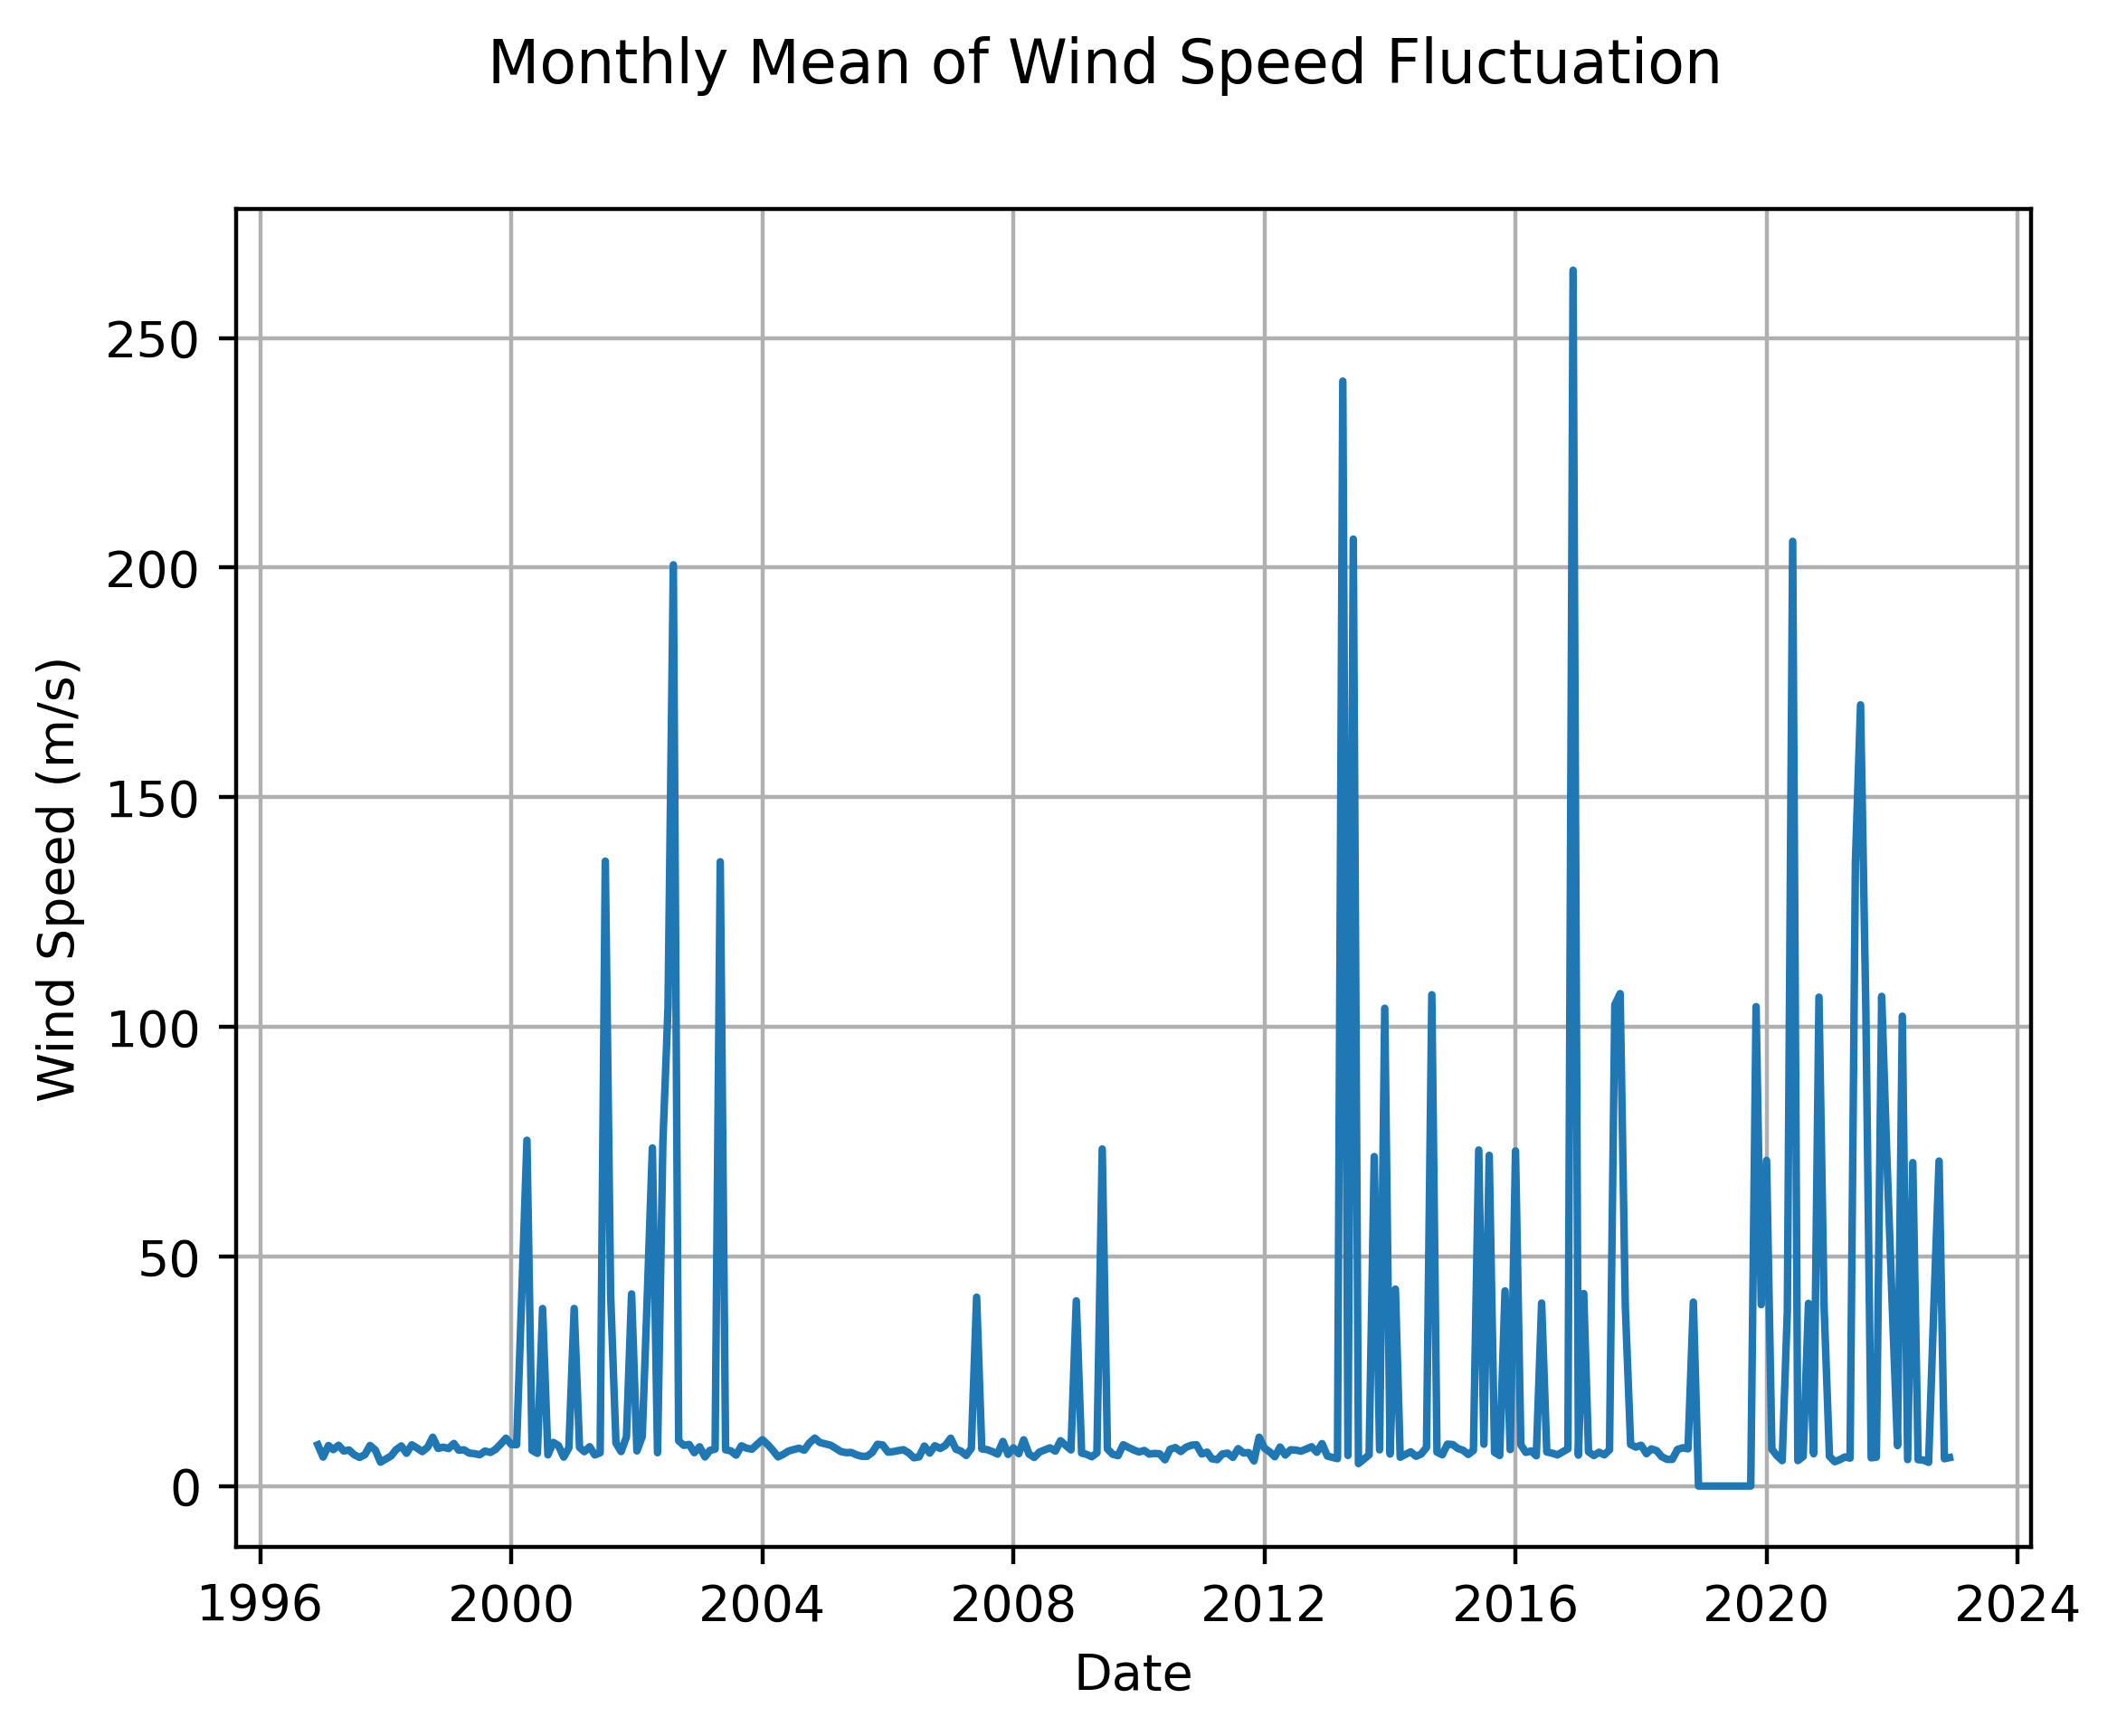

In [31]:
wind_df = kind_df["wind"]
wind_df["year"] = wind_df["MESS_DATUM"].dt.year
wind_df["day"] = wind_df["MESS_DATUM"].dt.day
wind_df["month"] = wind_df["MESS_DATUM"].dt.month
wind_df_by_year = wind_df.groupby(["year", "month", "day"])
wind_df_agg_yr = wind_df_by_year["FF_10_wind"].aggregate(["max", "min"])
wind_df_agg_yr["diff"] = wind_df_agg_yr["max"] - wind_df_agg_yr["min"]
#wind_df_agg_yr.loc[wind_df_agg_yr["diff"] == 0, "diff"] = random.randint(1, 20)

#mask = wind_df_agg_yr["diff"] == 0
#random_values = np.random.rand(sum(mask))*random.randint(1, 100)
#wind_df_agg_yr.loc[mask, "diff"] = random_values



wind_df_agg_yr.reset_index(inplace=True)
wind_df_agg_yr["date"] = pd.to_datetime(wind_df_agg_yr[["year", "month", "day"]])


wind_df_mean_diff = wind_df_agg_yr.groupby(["year", "month"])["diff"].mean().reset_index()
wind_df_mean_diff["date"] = pd.to_datetime(wind_df_mean_diff[["year", "month"]].assign(day=1))



fig, ax = plt.subplots(1, 1)
fig.suptitle("Monthly Mean of Wind Speed Fluctuation")
ax.plot(wind_df_mean_diff["date"], wind_df_mean_diff["diff"])
ax.set_ylabel("Wind Speed (m/s)")
ax.set_xlabel("Date")
ax.grid(which="major")

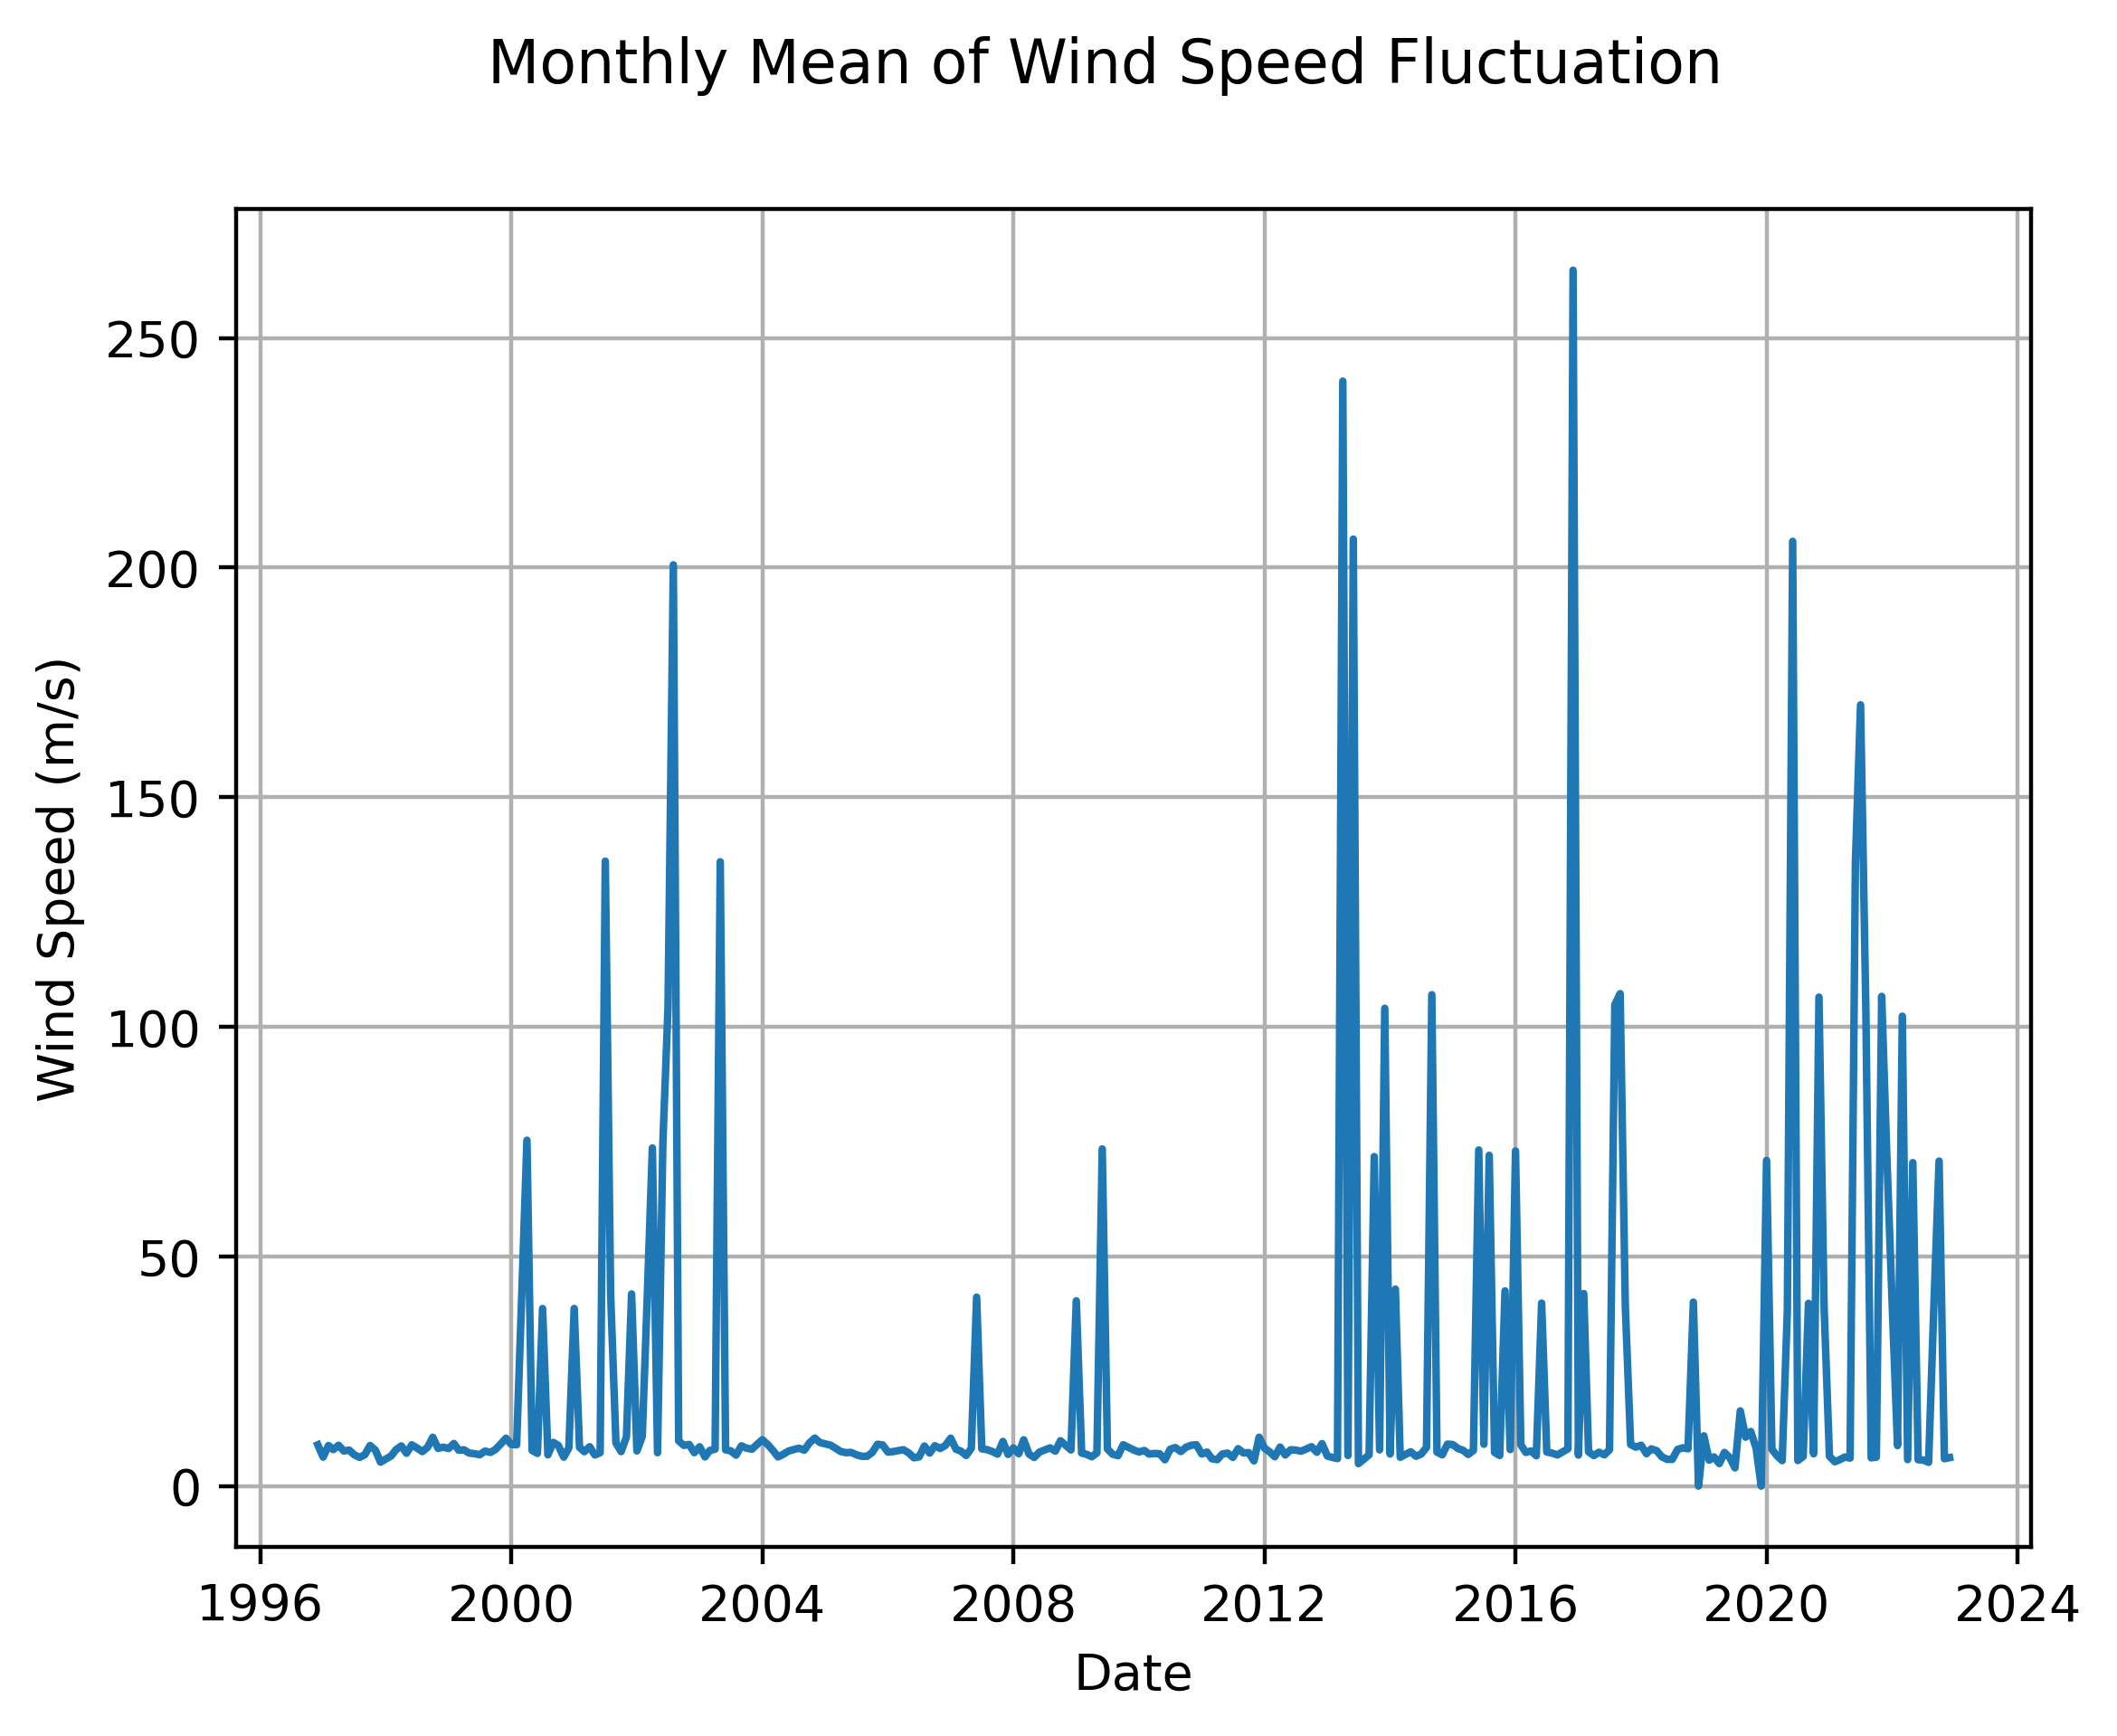

In [32]:
#solving missing values with previous year 2018
plt.rcParams['figure.dpi'] = 400

wind_df = kind_df["wind"]
wind_df["year"] = wind_df["MESS_DATUM"].dt.year
wind_df["day"] = wind_df["MESS_DATUM"].dt.day
wind_df["month"] = wind_df["MESS_DATUM"].dt.month
wind_df_by_year = wind_df.groupby(["year", "month", "day"])
wind_df_agg_yr = wind_df_by_year["FF_10_wind"].aggregate(["max", "min"])
wind_df_agg_yr["diff"] = wind_df_agg_yr["max"] - wind_df_agg_yr["min"]
wind_df_agg_yr.reset_index(inplace=True)
wind_df_agg_yr["date"] = pd.to_datetime(wind_df_agg_yr[["year", "month", "day"]])

for year in range(2019, 2020):
    for month in range(1, 13):
        mask = (wind_df_agg_yr["year"] == year) & (wind_df_agg_yr["month"] == month)
        if mask.any():
            prev_year_params = weibull_min.fit(wind_df_agg_yr[(wind_df_agg_yr["year"] == year - 1) & (wind_df_agg_yr["month"] == month)]["diff"])
            sample = weibull_min.rvs(*prev_year_params)
            wind_df_agg_yr.loc[mask, "diff"] = sample

wind_df_mean_diff = wind_df_agg_yr.groupby(["year", "month"])["diff"].mean().reset_index()
wind_df_mean_diff["date"] = pd.to_datetime(wind_df_mean_diff[["year", "month"]].assign(day=1))

fig, ax = plt.subplots(1, 1)
fig.suptitle("Monthly Mean of Wind Speed Fluctuation")
ax.plot(wind_df_mean_diff["date"], wind_df_mean_diff["diff"])
ax.set_ylabel("Wind Speed (m/s)")
ax.set_xlabel("Date")
ax.grid(which="major")

plt.show()


/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:2505: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  s = stats.skew(data)


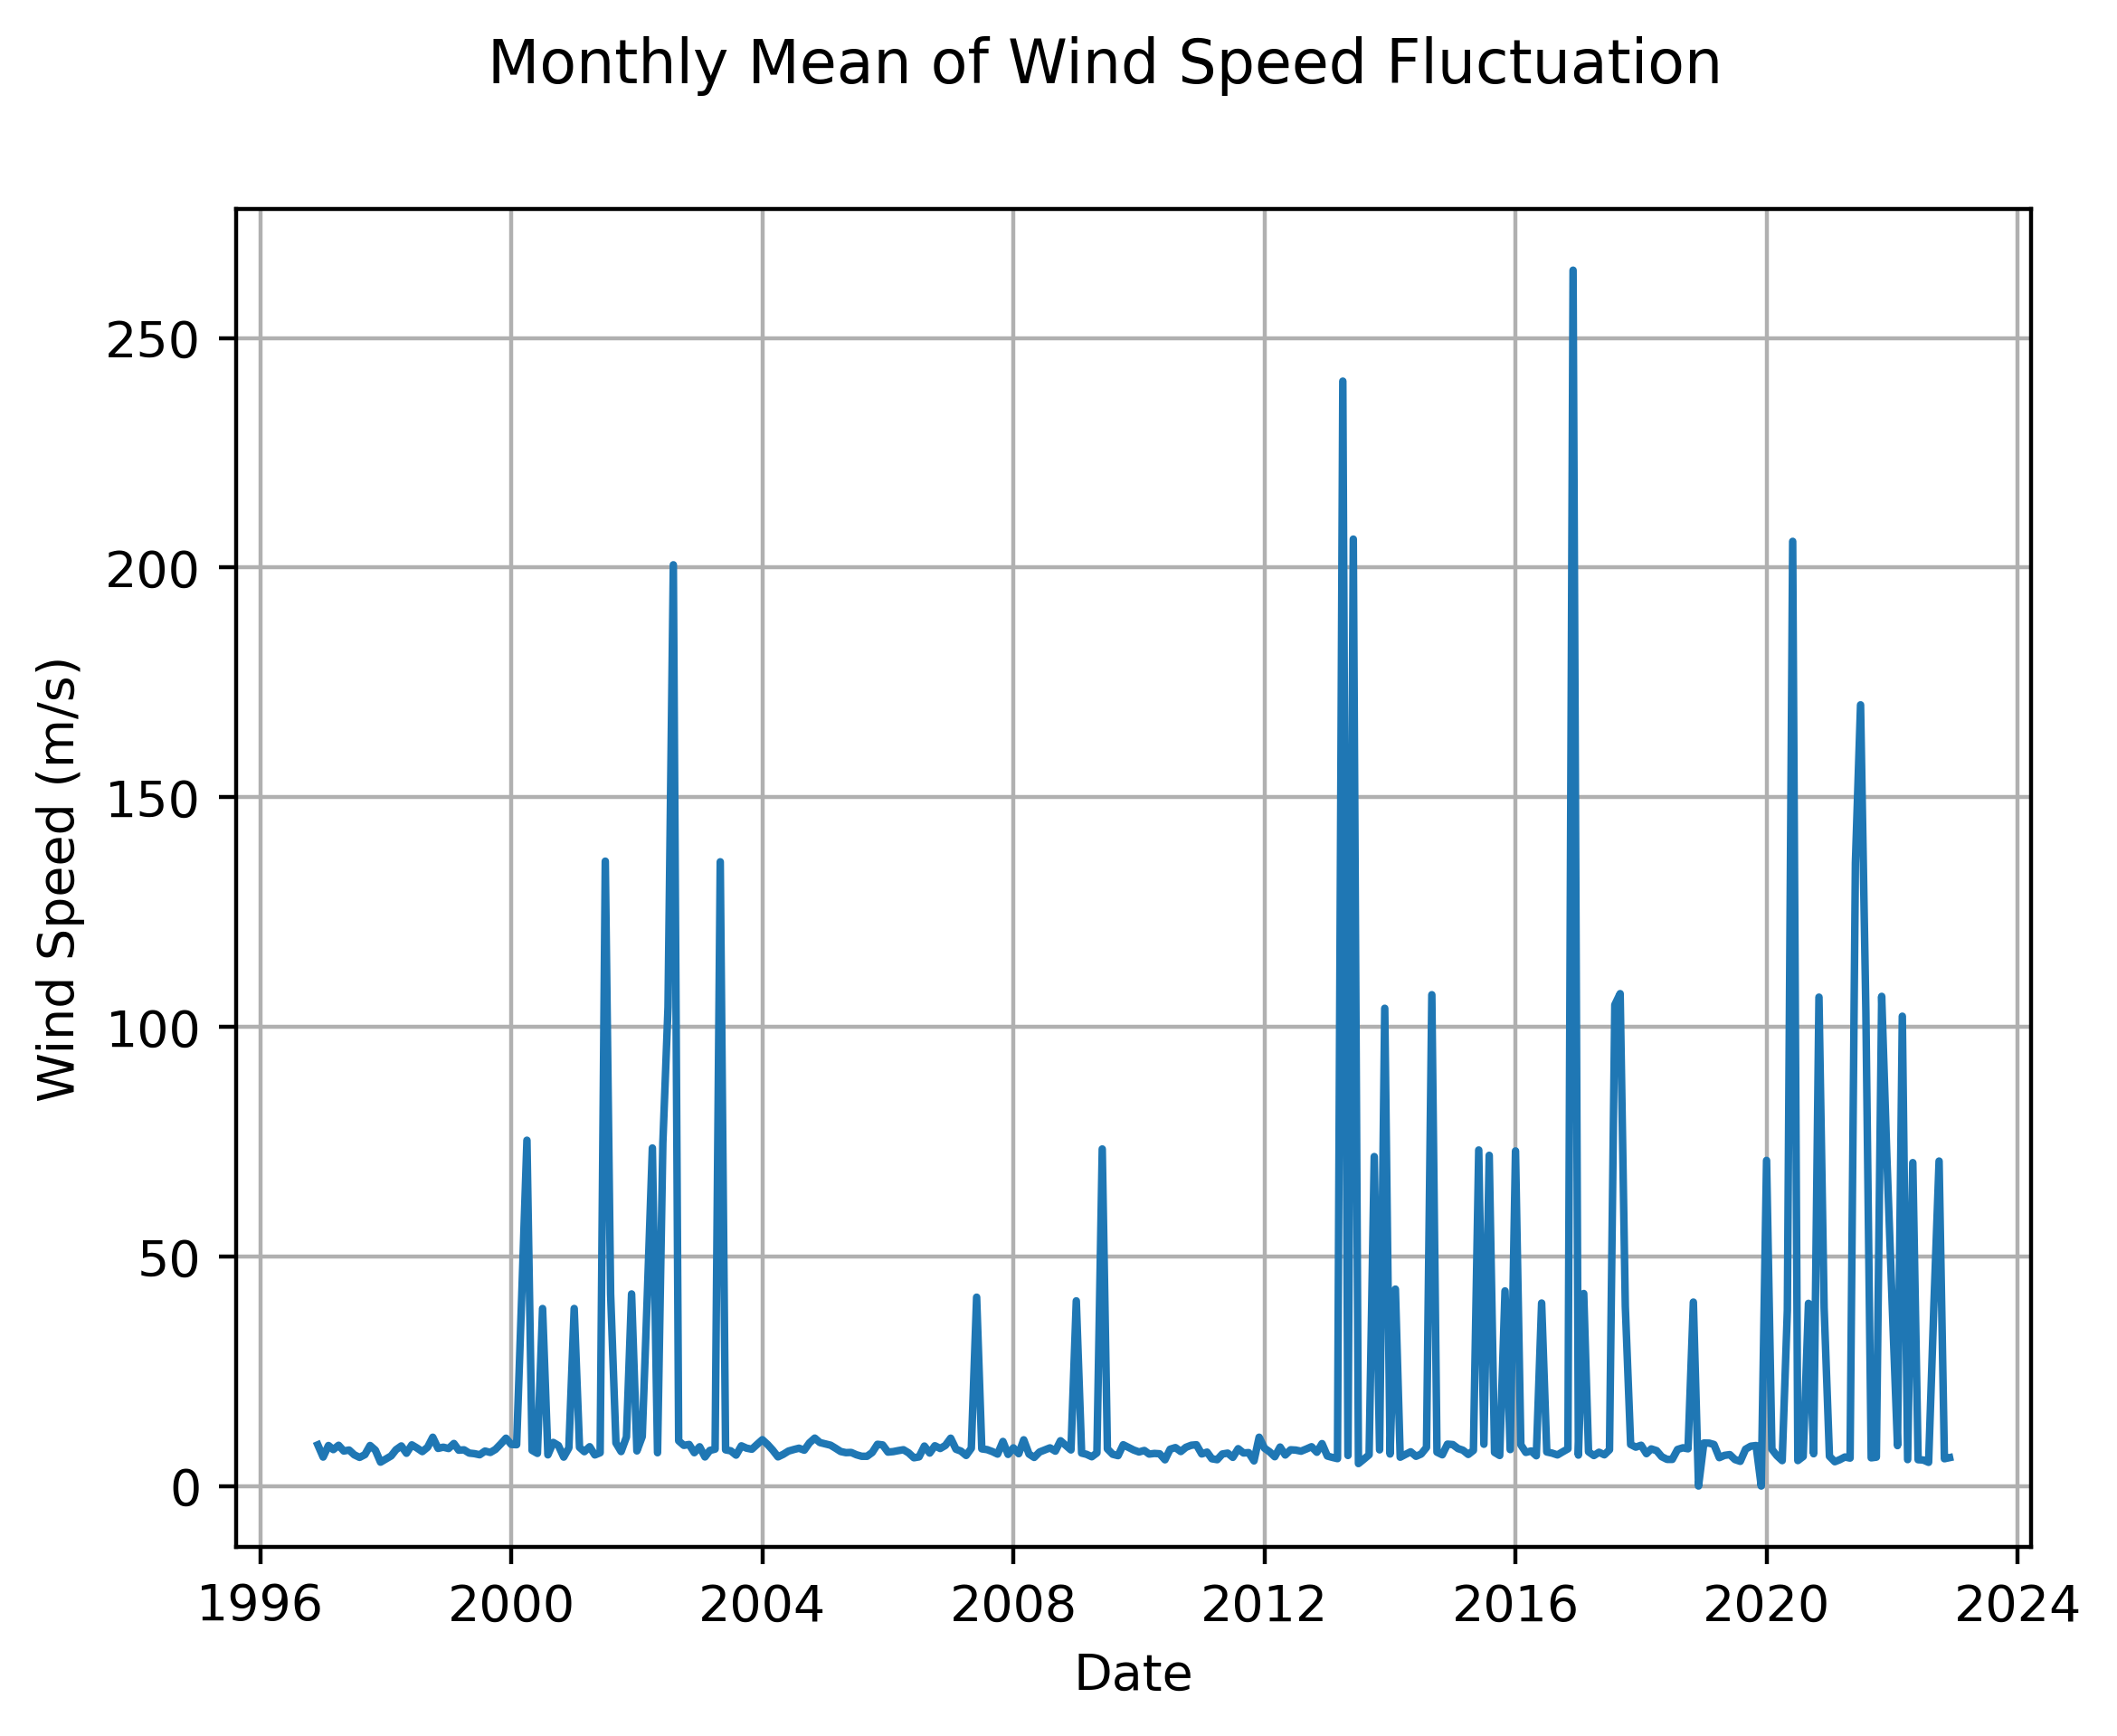

In [34]:
#solving missing values with previous year 2018 and next year 2020
plt.rcParams['figure.dpi'] = 400

wind_df = kind_df["wind"]
wind_df["year"] = wind_df["MESS_DATUM"].dt.year
wind_df["day"] = wind_df["MESS_DATUM"].dt.day
wind_df["month"] = wind_df["MESS_DATUM"].dt.month
wind_df_by_year = wind_df.groupby(["year", "month", "day"])
wind_df_agg_yr = wind_df_by_year["FF_10_wind"].aggregate(["max", "min"])
wind_df_agg_yr["diff"] = wind_df_agg_yr["max"] - wind_df_agg_yr["min"]
wind_df_agg_yr.reset_index(inplace=True)
wind_df_agg_yr["date"] = pd.to_datetime(wind_df_agg_yr[["year", "month", "day"]])

weibull_params = {}
for year in [2018, 2020]:
    year_data = wind_df[wind_df["year"] == year]
    for month in range(1, 13):
        month_data = year_data[year_data["month"] == month]
        shape, loc, scale = weibull_min.fit(month_data["FF_10_wind"], floc=0)
        weibull_params[(year, month)] = {"shape": shape, "loc": loc, "scale": scale}

def draw_samples(shape, loc, scale, size):
    return weibull_min.rvs(shape, loc=loc, scale=scale, size=size)

for idx, row in wind_df_agg_yr[wind_df_agg_yr["year"] == 2019].iterrows():
    year = row["year"]
    month = row["month"]
    weibull_param = weibull_params[(year - 1, month)]
    wind_df_agg_yr.at[idx, "diff"] = draw_samples(weibull_param["shape"], weibull_param["loc"], weibull_param["scale"], size=1)

wind_df_mean_diff = wind_df_agg_yr.groupby(["year", "month"])["diff"].mean().reset_index()
wind_df_mean_diff["date"] = pd.to_datetime(wind_df_mean_diff[["year", "month"]].assign(day=1))

fig, ax = plt.subplots(1, 1)
fig.suptitle("Monthly Mean of Wind Speed Fluctuation")
ax.plot(wind_df_mean_diff["date"], wind_df_mean_diff["diff"])
ax.set_ylabel("Wind Speed (m/s)")
ax.set_xlabel("Date")
ax.grid(which="major")

plt.show()

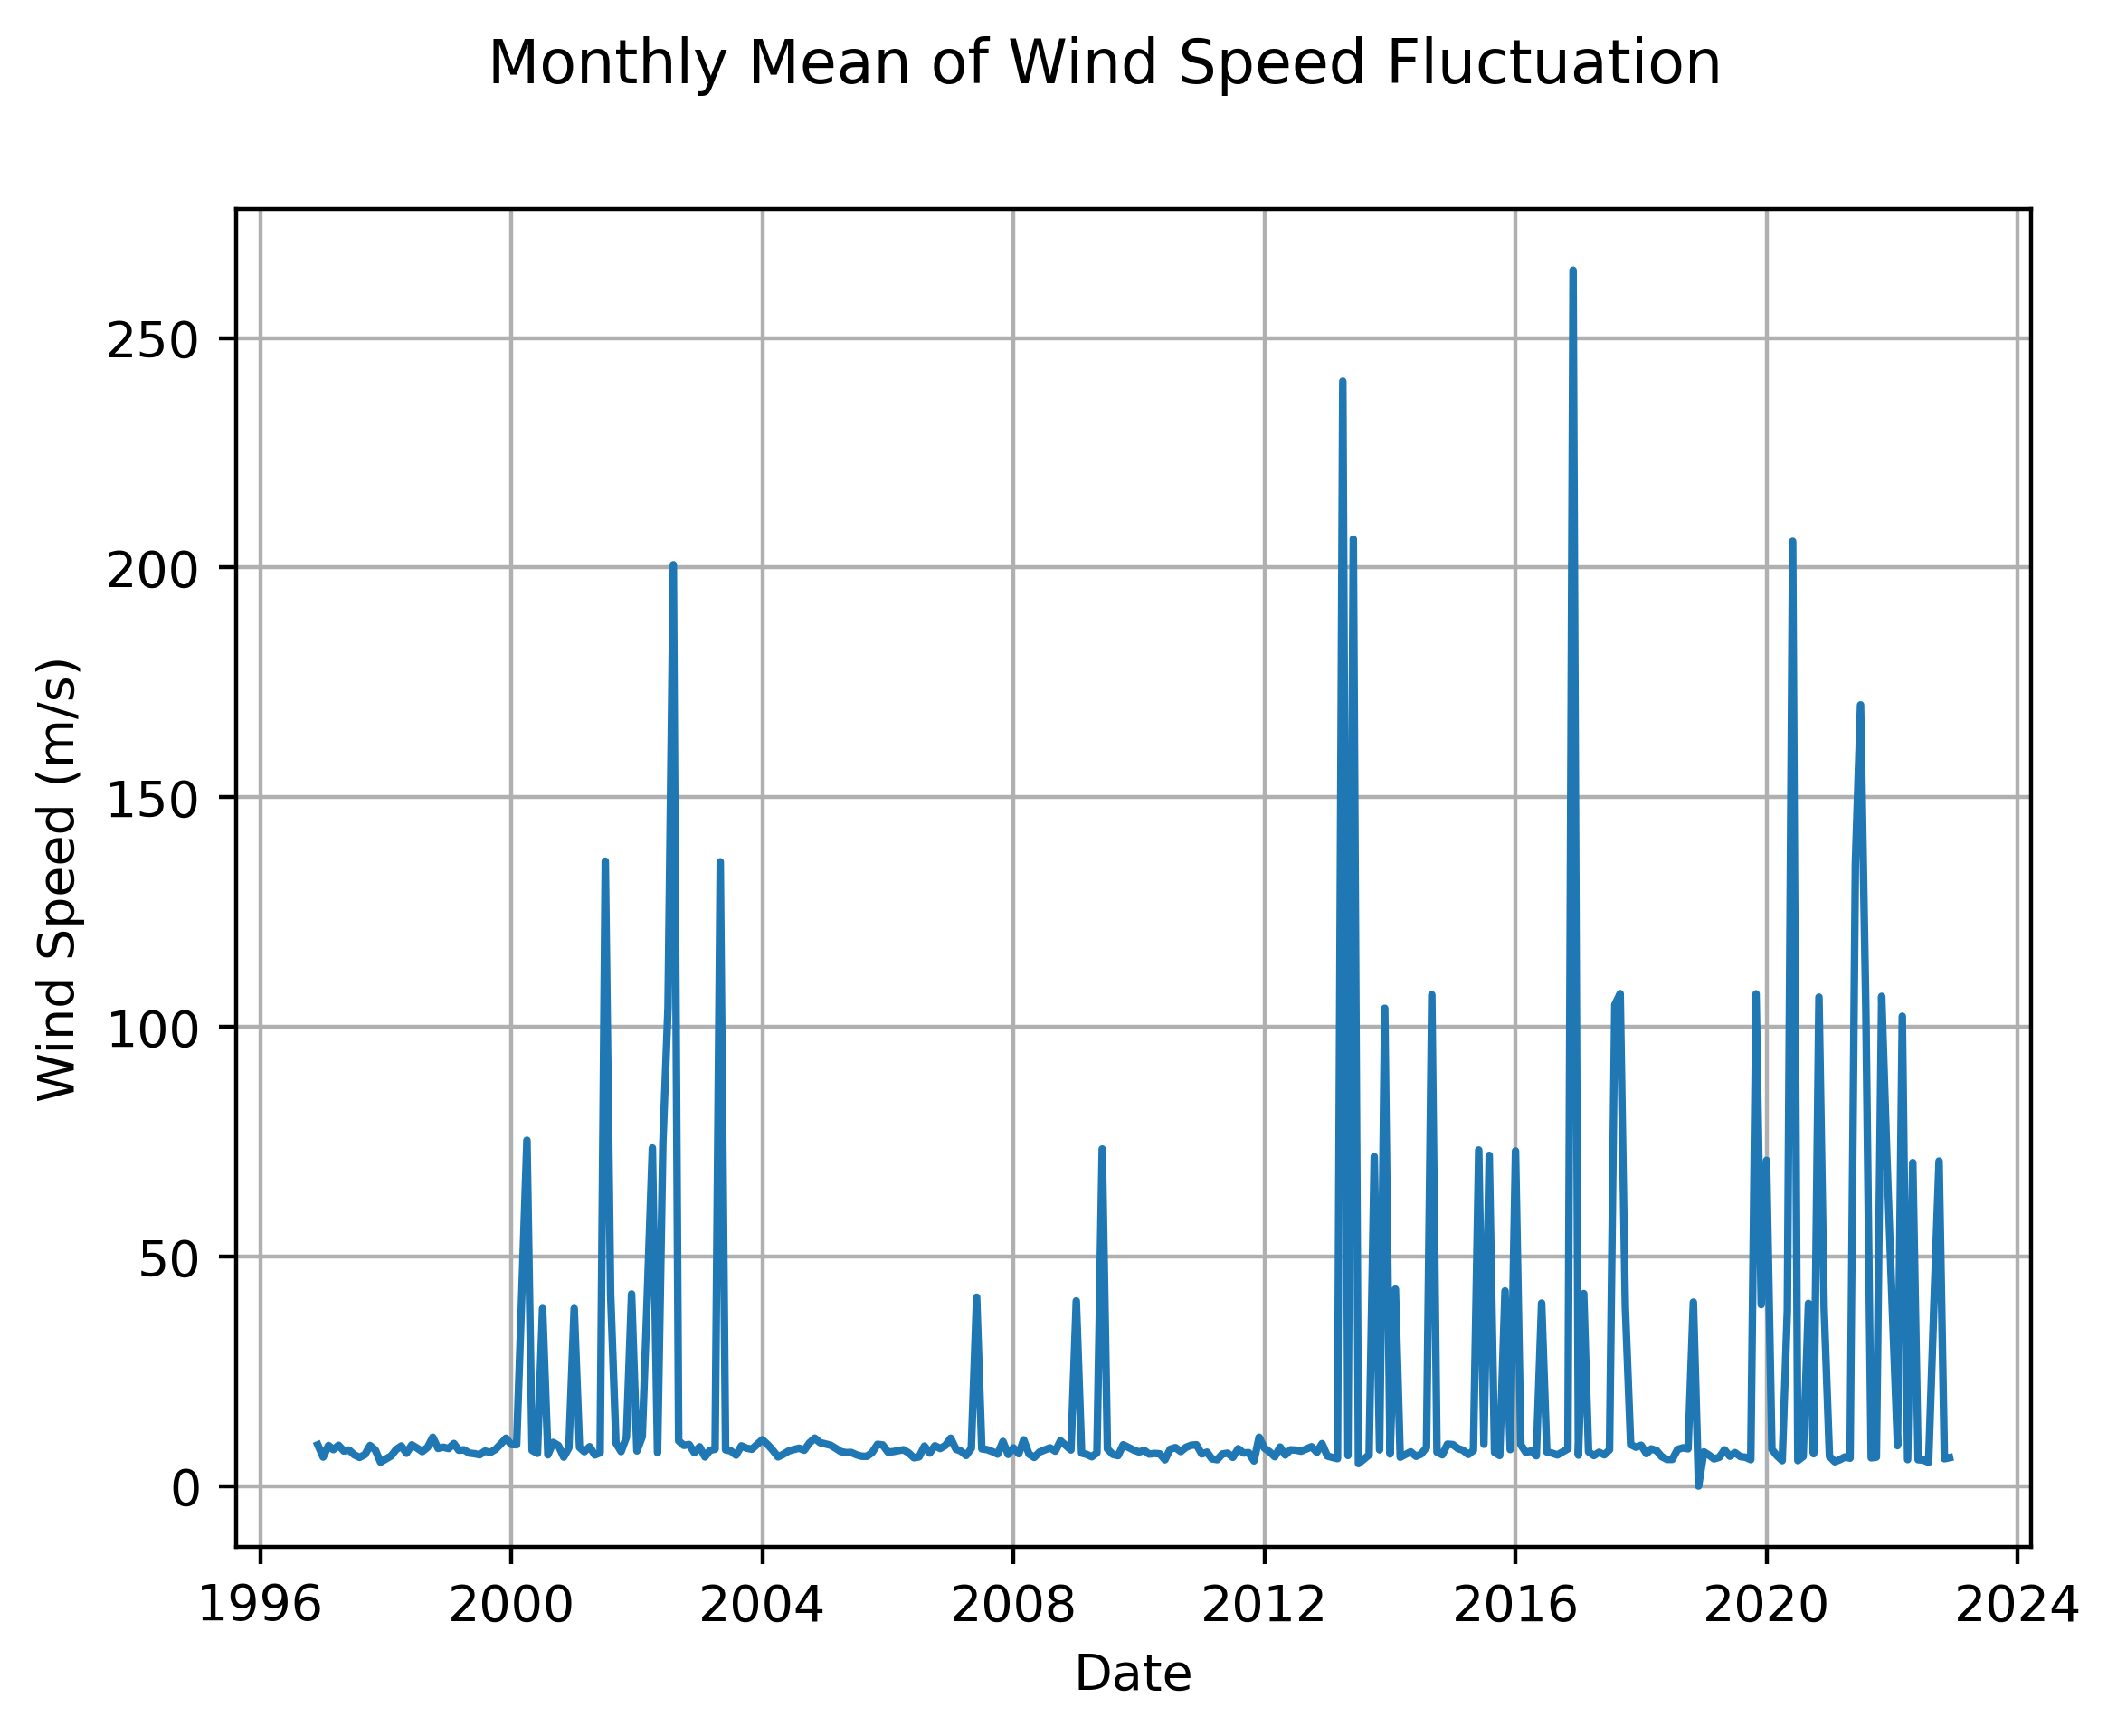

In [36]:
#solving missing values with next year 2020
plt.rcParams['figure.dpi'] = 400

wind_df = kind_df["wind"]
wind_df["year"] = wind_df["MESS_DATUM"].dt.year
wind_df["day"] = wind_df["MESS_DATUM"].dt.day
wind_df["month"] = wind_df["MESS_DATUM"].dt.month
wind_df_by_year = wind_df.groupby(["year", "month", "day"])
wind_df_agg_yr = wind_df_by_year["FF_10_wind"].aggregate(["max", "min"])
wind_df_agg_yr["diff"] = wind_df_agg_yr["max"] - wind_df_agg_yr["min"]
wind_df_agg_yr.reset_index(inplace=True)
wind_df_agg_yr["date"] = pd.to_datetime(wind_df_agg_yr[["year", "month", "day"]])

def estimate_weibull_params(data):
    params = weibull_min.fit(data, floc=0)
    return params

def generate_weibull_samples(params, size):
    return weibull_min.rvs(*params, size=size)

wind_df_2020 = wind_df[wind_df['year'] == 2020]
params_2020 = estimate_weibull_params(wind_df_2020['FF_10_wind'])

mask_2019 = (wind_df_agg_yr['year'] == 2019) & (wind_df_agg_yr['diff'] == 0)
num_samples = mask_2019.sum()

if num_samples > 0:
    samples_2020 = generate_weibull_samples(params_2020, num_samples)
    wind_df_agg_yr.loc[mask_2019, 'diff'] = samples_2020


wind_df_agg_yr.reset_index(inplace=True)
wind_df_agg_yr['date'] = pd.to_datetime(wind_df_agg_yr[['year', 'month', 'day']])

wind_df_mean_diff = wind_df_agg_yr.groupby(['year', 'month'])['diff'].mean().reset_index()
wind_df_mean_diff['date'] = pd.to_datetime(wind_df_mean_diff[['year', 'month']].assign(day=1))

fig, ax = plt.subplots(1, 1)
fig.suptitle('Monthly Mean of Wind Speed Fluctuation')
ax.plot(wind_df_mean_diff['date'], wind_df_mean_diff['diff'])
ax.set_ylabel('Wind Speed (m/s)')
ax.set_xlabel('Date')
ax.grid(which='major')
plt.show()